In [1]:
import os
import wfdb
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

def load_mitbih_dataset(path):
    # Define a list of annotation symbols that represent different types of heartbeats
    annots_list = ['N', 'L', 'R', 'e', 'j', 'S', 'A', 'a', 'J', 'V', 'E', 'F', '/', 'f', 'Q']

    # Prepare empty lists to store signal segments and corresponding labels
    X = []
    y = []

    # Create a dictionary to map each annotation symbol to a unique integer
    annot_to_int = {annot: i for i, annot in enumerate(annots_list)}

    # Read the list of ECG record filenames from the 'RECORDS' file in the dataset directory
    record_list = []
    with open(os.path.join(path, 'RECORDS'), 'r') as file:
        record_list = [line.strip() for line in file]

    # Create an instance of the MinMaxScaler to scale each segment to the range [0, 1]
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Iterate over each record file in the dataset
    for record_name in record_list:
        # Load the ECG record and its annotations using the wfdb library
        record = wfdb.rdrecord(os.path.join(path, record_name))
        annotation = wfdb.rdann(os.path.join(path, record_name), 'atr')

        # Extract the first channel of the ECG signal (assuming it's a single-channel ECG)
        signal = record.p_signal[:, 0]
        # Get the symbols and sample locations for each annotated beat
        beat_annotations = annotation.symbol
        beat_locations = annotation.sample

        # Process each annotated beat in the current record
        for sym, loc in zip(beat_annotations, beat_locations):
            # Check if the annotation symbol is one of the types we're interested in
            if sym in annots_list:
                # Convert the annotation symbol to its corresponding integer label
                label = annot_to_int[sym]
                
                # Define the window size around the beat location to extract the segment
                win_size = 625  # This results in segments of 1250 samples centered on the beat
                # Ensure that the window does not extend beyond the signal boundaries
                if loc - win_size >= 0 and loc + win_size <= len(signal):
                    # Extract the segment of the signal centered around the beat
                    segment = signal[loc - win_size: loc + win_size]
                    # Normalize the segment to the range [0, 1]
                    segment = scaler.fit_transform(segment.reshape(-1, 1)).flatten()
                    # Add the normalized segment to the list of segments
                    X.append(segment)
                    # Add the label to the list of labels
                    y.append(label)

    # Convert the lists of segments and labels to numpy arrays for use in machine learning models
    X = np.array(X)
    # Convert the integer labels to one-hot encoded format
    y = to_categorical(y, num_classes=len(annots_list))

    return X, y


2024-04-22 18:48:27.595992: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 18:48:27.752460: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 18:48:27.752527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 18:48:27.771444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 18:48:27.809905: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# # #run this step just onceeeeeeeeee, next time just load from the saved train test
# import numpy as np
# from sklearn.model_selection import train_test_split

# # Load your dataset
# X, y = load_mitbih_dataset("/home/researchgroup/mahjabeen_workspace/research/CLINet-ECG-Classification-2024/data/mit-bih/mitbih_database/")

# # Step 1: Perform the split once
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# # Step 2: Save the split data to disk
# np.save('./X_train.npy', X_train)
# np.save('./X_test.npy', X_test)
# np.save('./y_train.npy', y_train)
# np.save('./y_test.npy', y_test)

# # In future sessions, you can load the datasets directly from the saved files:
# # X_train = np.load('./X_train.npy')
# # X_test = np.load('./X_test.npy')
# # y_train = np.load('./y_train.npy')
# # y_test = np.load('./y_test.npy')

# # Use X_train, X_test, y_train, y_test for model training and evaluations


In [3]:
#create_lstm_model
# This function is responsible for:


# Defining the input layer with the specified input shape.
# Constructing three convolutional layers with increasing numbers of filters, each followed by batch normalization.
# Adding a TimeDistributed layer to flatten the output in preparation for the LSTM layer.
# Incorporating an LSTM layer with 200 units.
# Applying dropout after the LSTM layer for regularization.
# Including a dense layer with ReLU activation, followed by another dropout layer.
# Creating the output layer with a softmax activation function that provides probabilities for each class.
# Allowing the choice of either the Adam or SGD optimizer based on the optimizer_type parameter.
# Compiling the model with a categorical cross-entropy loss function and metrics for accuracy, precision, and recall.
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, TimeDistributed, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, TimeDistributed, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision, Recall

def create_lstm_model(num_classes, input_shape=(1250, 1), optimizer_type='adam', learning_rate=0.001):
    # Define the input layer with the specified input shape, which is expected to be the size of the ECG segments
    inputs = Input(shape=input_shape)
    
    # First convolutional layer with 32 filters and a kernel size of 5; padding is set to 'same' to keep the output size equal to input size
    x = Conv1D(32, 5, strides=1, padding='same', activation='relu')(inputs)
    # Apply batch normalization to stabilize learning and improve convergence; it normalizes the activations from the previous layer
    x = BatchNormalization()(x)
    
    # Second convolutional layer increasing the number of filters to 64, helping to capture more complex features in the data
    x = Conv1D(64, 5, strides=1, padding='same', activation='relu')(x)
    # Another batch normalization to help the deeper layers train faster and more effectively
    x = BatchNormalization()(x)
    
    # Third convolutional layer with 128 filters to further enhance the network's ability to learn detailed features
    x = Conv1D(128, 5, strides=1, padding='same', activation='relu')(x)
    # Final batch normalization to maintain the benefits through to deeper parts of the network
    x = BatchNormalization()(x)

    # Flatten the output of the last convolutional layer to prepare for the LSTM layer
    # TimeDistributed wrapper allows the LSTM to process each time step of each sequence independently
    x = TimeDistributed(Flatten())(x)
    # LSTM layer with 200 units to capture long-term dependencies in the ECG signal; return_sequences is False as we want the final output only
    x = LSTM(200, return_sequences=False)(x)
    
    # Dense layer with dropout for regularization; dropout helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time
    x = Dropout(0.5)(x)  # Using high dropout rate for regularization
    x = Dense(100, activation='relu')(x)  # Dense layer with 100 neurons
    x = Dropout(0.5)(x)  # Additional dropout for added regularization
    
    # Output layer with a softmax activation to obtain probabilities for each class; num_classes determines the number of ECG classes
    outputs = Dense(num_classes, activation='softmax')(x)

    # Conditional selection of optimizer: 'adam' for adaptive moment estimation or 'sgd' for stochastic gradient descent with momentum
    if optimizer_type == 'adam':
        optimizer = Adam(learning_rate=learning_rate)  # Adam optimizer with the specified learning rate
    else:
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)  # SGD optimizer with momentum

    # Compile the model specifying the optimizer, loss function, and metrics for evaluation
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

    return model


In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import json
def train_and_save_model():
    # Load pre-split data from disk, which is expected to be in NumPy array format
    X_train = np.load('./X_train.npy')
    X_test = np.load('./X_test.npy')
    y_train = np.load('./y_train.npy')
    y_test = np.load('./y_test.npy')
    
    # Reshape the data to fit the LSTM input requirement of [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Define paths for the model and training history files
    model_path = './final_model.h5'
    history_path = './model_history.json'

    # Check if the model and history files already exist to avoid retraining
    if os.path.exists(model_path) and os.path.exists(history_path):
        print("Model and training history already exist. Loading...")
        model = keras.models.load_model(model_path)  # Load the pre-trained model
        with open(history_path, 'r') as f:
            history = json.load(f)  # Load the training history
    else:
        print("Training new model...")
        # Initialize and compile the LSTM model
        model = create_lstm_model(num_classes=y_train.shape[1], input_shape=(X_train.shape[1], 1))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

        # Set up callbacks for saving the best model, early stopping, and reducing learning rate on plateau
        callbacks = [
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1),
            keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, verbose=1),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
        ]

        # Train the model
        history = model.fit(X_train, y_train, epochs=50, batch_size=64, 
                            validation_data=(X_test, y_test), callbacks=callbacks)
        print("Training completed. Model saved.")
        # Convert the training history to native Python types
        history_dict = {k: [float(val) for val in v] for k, v in history.history.items()}
         # Save the training history to a JSON file
        with open(history_path, 'w') as f:
            json.dump(history.history, f)
            print("Training history saved.")

    return model, history
def plot_learning_curves(history):
    # Plot the learning curves for accuracy and loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.show()

if __name__ == "__main__":
    model, history = train_and_save_model()
    plot_learning_curves(history)

Training new model...


2024-04-22 19:48:10.024026: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8231 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-04-22 19:48:10.024943: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 8074 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:68:00.0, compute capability: 8.6


Epoch 1/50


2024-04-22 19:48:13.785435: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-22 19:48:15.614738: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f026817bf20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-22 19:48:15.614786: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-04-22 19:48:15.614798: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-04-22 19:48:15.634761: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713840495.760858   18037 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1367/1367 [==============================] - ETA: 0s - loss: 1.0001 - accuracy: 0.7210 - precision_1: 0.7662 - recall_1: 0.6326
Epoch 1: val_loss improved from inf to 0.68408, saving model to ./final_model.h5
1367/1367 [==============================] - 102s 70ms/step - loss: 1.0001 - accuracy: 0.7210 - precision_1: 0.7662 - recall_1: 0.6326 - val_loss: 0.6841 - val_accuracy: 0.7874 - val_precision_1: 0.8218 - val_recall_1: 0.7494 - lr: 0.0010
Epoch 2/50
   1/1367 [..............................] - ETA: 1:31 - loss: 0.8101 - accuracy: 0.7969 - precision_1: 0.8421 - recall_1: 0.7500

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1367/1367 [==============================] - ETA: 0s - loss: 0.6830 - accuracy: 0.8035 - precision_1: 0.8438 - recall_1: 0.7496
Epoch 2: val_loss improved from 0.68408 to 0.60114, saving model to ./final_model.h5
1367/1367 [==============================] - 96s 71ms/step - loss: 0.6830 - accuracy: 0.8035 - precision_1: 0.8438 - recall_1: 0.7496 - val_loss: 0.6011 - val_accuracy: 0.8228 - val_precision_1: 0.8546 - val_recall_1: 0.7869 - lr: 0.0010
Epoch 3/50
1367/1367 [==============================] - ETA: 0s - loss: 0.5826 - accuracy: 0.8355 - precision_1: 0.8660 - recall_1: 0.7962
Epoch 3: val_loss improved from 0.60114 to 0.48906, saving model to ./final_model.h5
1367/1367 [==============================] - 96s 70ms/step - loss: 0.5826 - accuracy: 0.8355 - precision_1: 0.8660 - recall_1: 0.7962 - val_loss: 0.4891 - val_accuracy: 0.8554 - val_precision_1: 0.8696 - val_recall_1: 0.8402 - lr: 0.0010
Epoch 4/50
1367/1367 [==============================] - ETA: 0s - loss: 0.6733 - accura

TypeError: Object of type float32 is not JSON serializable

Model loaded successfully.
684/684 [==============================] - 18s 26ms/step - loss: 0.1769 - accuracy: 0.9445 - precision_1: 0.9502 - recall_1: 0.9404
Test Loss, Test Accuracy, and other metrics: [0.17693544924259186, 0.9445054531097412, 0.9501710534095764, 0.9404336810112]
684/684 [==============================] - 14s 20ms/step


/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Classification Report:
              precision    recall  f1-score   support

           N       0.95      0.99      0.97     14995
           L       0.97      0.98      0.98      1594
           R       0.96      0.98      0.97      1500
           e       0.00      0.00      0.00         2
           j       0.52      0.33      0.40        49
           S       0.00      0.00      0.00         1
           A       0.92      0.63      0.75       467
           a       0.00      0.00      0.00        27
           J       1.00      0.25      0.40        12
           V       0.89      0.60      0.72      1444
           E       1.00      0.94      0.97        16
           F       0.68      0.30      0.41       145
           /       0.95      0.98      0.97      1408
           f       0.77      0.66      0.71       182
           Q       0.00      0.00      0.00        16

    accuracy                           0.94     21858
   macro avg       0.64      0.51      0.55     21858
we

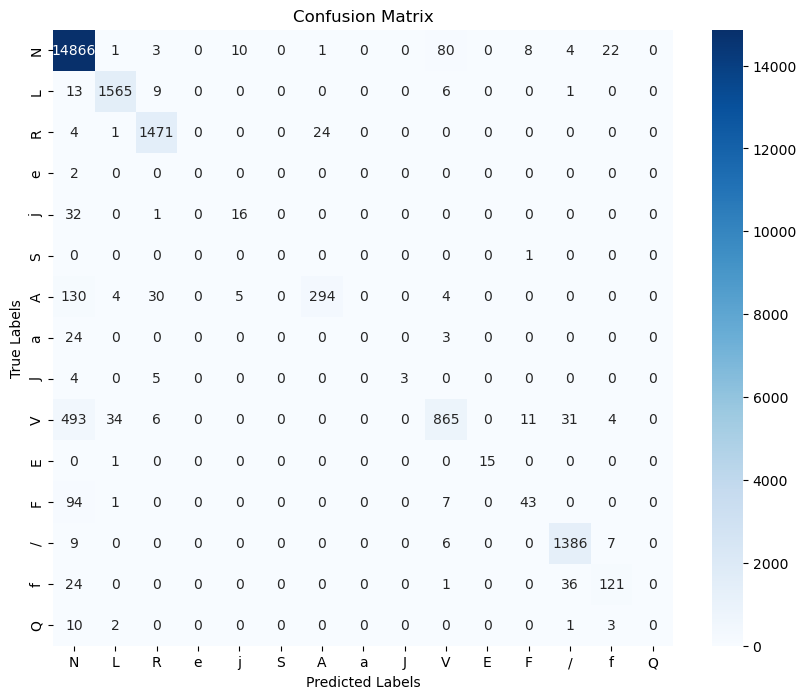

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Define the class labels based on your annots_list
class_labels = ['N', 'L', 'R', 'e', 'j', 'S', 'A', 'a', 'J', 'V', 'E', 'F', '/', 'f', 'Q']

def load_and_evaluate(threshold=0.5):
    # Load the test data
    X_test = np.load('./X_test.npy')
    y_test = np.load('./y_test.npy')
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  # Reshape for CNNs or LSTMs

    # Load the trained model
    model_path = './final_model.h5'
    if not os.path.exists(model_path):
        print("Model file not found!")
        return
    model = keras.models.load_model(model_path)
    print("Model loaded successfully.")

    # Evaluate the model on the test data
    results = model.evaluate(X_test, y_test, verbose=1)
    print(f'Test Loss, Test Accuracy, and other metrics: {results}')

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Generate a classification report with actual class labels
    report_dict = classification_report(y_true_classes, y_pred_classes, target_names=class_labels, output_dict=True)
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))

    # Identify underperforming classes based on the f1-score
    underperforming_classes = [cls for cls, metrics in report_dict.items() if cls in class_labels and metrics['f1-score'] < threshold]
    print(f"Underperforming classes: {underperforming_classes}")

    # Save the underperforming classes for focused training later
    with open('underperforming_classes.json', 'w') as f:
        json.dump(underperforming_classes, f)
        print("Underperforming classes saved.")

    # Confusion Matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return y_pred_classes

if __name__ == "__main__":
    predicted_classes = load_and_evaluate()


Training new model...
Epoch 1/50
1367/1367 [==============================] - ETA: 0s - loss: 4.4480 - accuracy: 0.0364 - precision_7: 0.0097 - recall_7: 1.0294e-04
Epoch 1: val_loss improved from inf to 2.63953, saving model to ./focused_final_model.h5
1367/1367 [==============================] - 100s 71ms/step - loss: 4.4480 - accuracy: 0.0364 - precision_7: 0.0097 - recall_7: 1.0294e-04 - val_loss: 2.6395 - val_accuracy: 0.0315 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - lr: 0.0010
Epoch 2/50
   2/1367 [..............................] - ETA: 1:18 - loss: 3.2460 - accuracy: 0.0547 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1367/1367 [==============================] - ETA: 0s - loss: 4.2447 - accuracy: 0.0183 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 2: val_loss did not improve from 2.63953
1367/1367 [==============================] - 96s 70ms/step - loss: 4.2447 - accuracy: 0.0183 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 2.7288 - val_accuracy: 0.0113 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - lr: 0.0010
Epoch 3/50
1367/1367 [==============================] - ETA: 0s - loss: 4.6090 - accuracy: 0.0105 - precision_7: 0.0068 - recall_7: 3.4314e-05
Epoch 3: val_loss did not improve from 2.63953
1367/1367 [==============================] - 96s 70ms/step - loss: 4.6090 - accuracy: 0.0105 - precision_7: 0.0068 - recall_7: 3.4314e-05 - val_loss: 2.7962 - val_accuracy: 0.0301 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - lr: 0.0010
Epoch 4/50
1367/1367 [==============================] - ETA: 0s - loss: 4.8638 - accuracy: 0.0109 - precision_7: 0.0047 - r

TypeError: 'History' object is not subscriptable

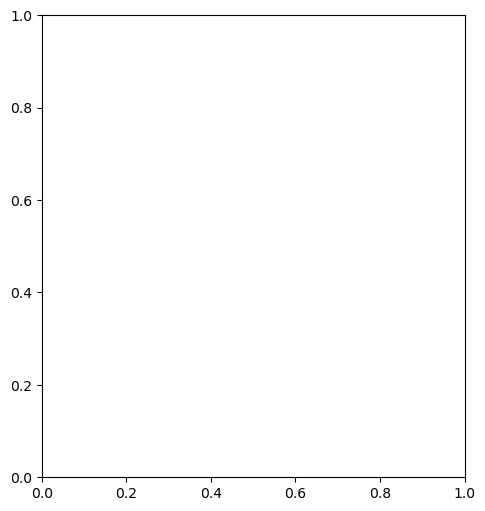

In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.utils.class_weight import compute_class_weight

class_labels = ['N', 'L', 'R', 'e', 'j', 'S', 'A', 'a', 'J', 'V', 'E', 'F', '/', 'f', 'Q']  # Assuming these are your class labels

def train_and_save_model(focused=False):
    # Load pre-split data from disk
    X_train = np.load('./X_train.npy')
    X_test = np.load('./X_test.npy')
    y_train = np.load('./y_train.npy')
    y_test = np.load('./y_test.npy')
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model_path = './final_model.h5' if not focused else './focused_final_model.h5'
    history_path = './model_history.json' if not focused else './focused_model_history.json'

    if os.path.exists(model_path) and os.path.exists(history_path):
        print("Model and training history already exist. Loading...")
        model = keras.models.load_model(model_path)
        with open(history_path, 'r') as f:
            history = json.load(f)
    else:
        print("Training new model...")
        model = create_lstm_model(num_classes=len(class_labels), input_shape=(X_train.shape[1], 1))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        # Convert one-hot encoded y_train to integer labels if necessary
        if len(y_train.shape) > 1 and y_train.shape[1] > 1:
            y_train_labels = np.argmax(y_train, axis=1)
        else:
            y_train_labels = y_train  # Assuming y_train is already in the correct format
        if focused:
            class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
            class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
            underperforming_indices = [class_labels.index(cls) for cls in underperforming_classes]
            for idx in underperforming_indices:
                class_weight_dict[idx] *= 2

        callbacks = [
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1),
            keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, verbose=1),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
        ]

        history = model.fit(X_train, y_train, epochs=50, batch_size=64, 
                            validation_data=(X_test, y_test), callbacks=callbacks, class_weight=class_weight_dict if focused else None)
        print("Training completed. Model saved.")

        history_dict = {k: [float(val) for val in v] for k, v in history.history.items()}
        with open(history_path, 'w') as f:
            json.dump(history_dict, f)
            print("Training history saved.")

    return model, history

def plot_learning_curves(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.show()

if __name__ == "__main__":
    underperforming_classes = ['e', 'j', 'S', 'a', 'J', 'F', 'Q']  # Example of underperforming classes
    focused = bool(underperforming_classes)  # Determine if the training should be focused
    model, history = train_and_save_model(focused=focused)
    plot_learning_curves(history)
